# Data analisis de sentimientos BITCOIN

In [8]:
# === 1. CARGA Y LIMPIEZA - TODAS LAS FECHAS A FORMATO ISO UTC (como NewsAPI) ===

import pandas as pd
from dateutil import parser as date_parser
import pytz

# Ruta al CSV crudo
path = "/workspaces/final-project/src/2025.12.17.noticias_raw_sentimiento.csv"

df = pd.read_csv(path)

print("Shape crudo:", df.shape)
display(df.head(3))

# 1. Función para convertir cualquier formato a ISO UTC con +00:00
def to_iso_utc(date_str):
    if pd.isna(date_str):
        return None
    try:
        # dateutil maneja RSS ("Wed, 17 Dec 2025...") y API ("2025-12-17T...")
        parsed = date_parser.parse(str(date_str))
        # Forzar a UTC
        if parsed.tzinfo is None:
            parsed = parsed.replace(tzinfo=pytz.UTC)
        else:
            parsed = parsed.astimezone(pytz.UTC)
        # Devolver formato ISO como NewsAPI: 2025-12-17T17:28:00+00:00
        return parsed.strftime('%Y-%m-%dT%H:%M:%S%z')
    except:
        return None

# Aplicar conversión
df['publishedAt'] = df['publishedAt'].apply(to_iso_utc)

# Eliminar las pocas que fallen (deberían ser 0 o muy pocas)
before = len(df)
df = df.dropna(subset=['publishedAt']).copy()
print(f"Filas después de conversión de fechas: {len(df)} (perdidas: {before - len(df)})")

# 2. Convertir a datetime para operaciones (floor, etc.)
df['datetime'] = pd.to_datetime(df['publishedAt'])

# 3. Bloque de 1 hora (para Carlos)
df['datetime_1h'] = df['datetime'].dt.floor('1h')

# 4. text_nlp limpia
df['text_nlp'] = df['title'].astype(str).str.strip() + " " + df['description'].astype(str).fillna('').str.strip()
df['text_nlp'] = df['text_nlp'].str.strip()

# 5. Limpiar source
df['source'] = df['source'].str.replace(' RSS', '', case=False).str.strip().str.title()

# 6. Quitar duplicados
df = df.drop_duplicates(subset=['title', 'publishedAt']).reset_index(drop=True)

print(f"\n✅ Limpieza completada: {len(df)} artículos únicos")
print(f"Rango temporal: {df['datetime'].min()} → {df['datetime'].max()}")
print("\nEjemplo de publishedAt estandarizado (como NewsAPI):")
print(df['publishedAt'].head(10).tolist())

display(df.head(5))

Shape crudo: (6580, 5)


,publishedAt,title,description,source,axis
0,"Wed, 17 Dec 2025 17:28:00 +0000",Polkadot's DOT drops 3% to $1.83 as crypto mar...,NaN,"CoinDesk: Bitcoin, Ethereum, Crypto News and P...",BTC
1,"Wed, 17 Dec 2025 17:20:57 +0000",BNB drops nearly 3% to as bitcoin whipsaw and ...,NaN,"CoinDesk: Bitcoin, Ethereum, Crypto News and P...",BTC
2,"Wed, 17 Dec 2025 17:14:34 +0000",Dogecoin and shiba inu test lower levels after...,NaN,"CoinDesk: Bitcoin, Ethereum, Crypto News and P...",BTC


Filas después de conversión de fechas: 6579 (perdidas: 1)

✅ Limpieza completada: 6428 artículos únicos
Rango temporal: 2025-03-09 15:36:58+00:00 → 2025-12-17 19:00:00+00:00

Ejemplo de publishedAt estandarizado (como NewsAPI):
['2025-12-17T17:28:00+0000', '2025-12-17T17:20:57+0000', '2025-12-17T17:14:34+0000', '2025-12-17T17:13:53+0000', '2025-12-17T17:06:18+0000', '2025-12-17T16:51:08+0000', '2025-12-17T16:43:02+0000', '2025-12-17T16:20:45+0000', '2025-12-17T16:11:57+0000', '2025-12-17T16:10:50+0000']


,publishedAt,title,description,source,axis,datetime,datetime_1h,text_nlp
0,2025-12-17T17:28:00+0000,Polkadot's DOT drops 3% to $1.83 as crypto mar...,NaN,"Coindesk: Bitcoin, Ethereum, Crypto News And P...",BTC,2025-12-17 17:28:00+00:00,2025-12-17 17:00:00+00:00,Polkadot's DOT drops 3% to $1.83 as crypto mar...
1,2025-12-17T17:20:57+0000,BNB drops nearly 3% to as bitcoin whipsaw and ...,NaN,"Coindesk: Bitcoin, Ethereum, Crypto News And P...",BTC,2025-12-17 17:20:57+00:00,2025-12-17 17:00:00+00:00,BNB drops nearly 3% to as bitcoin whipsaw and ...
2,2025-12-17T17:14:34+0000,Dogecoin and shiba inu test lower levels after...,NaN,"Coindesk: Bitcoin, Ethereum, Crypto News And P...",BTC,2025-12-17 17:14:34+00:00,2025-12-17 17:00:00+00:00,Dogecoin and shiba inu test lower levels after...
3,2025-12-17T17:13:53+0000,Crypto Long & Short: What the DOJ’s Massive Cr...,NaN,"Coindesk: Bitcoin, Ethereum, Crypto News And P...",BTC,2025-12-17 17:13:53+00:00,2025-12-17 17:00:00+00:00,Crypto Long & Short: What the DOJ’s Massive Cr...
4,2025-12-17T17:06:18+0000,XRP falls 5% as bitcoin’s sudden pump and dump...,NaN,"Coindesk: Bitcoin, Ethereum, Crypto News And P...",BTC,2025-12-17 17:06:18+00:00,2025-12-17 17:00:00+00:00,XRP falls 5% as bitcoin’s sudden pump and dump...


In [10]:
# === 2. SEPARAR POR EJE ===

df_btc   = df[df['axis'] == 'BTC'].copy()
df_tech  = df[df['axis'] == 'TECH'].copy()
df_macro = df[df['axis'] == 'MACRO'].copy()

print(f"BTC:   {len(df_btc)} artículos")
print(f"TECH:  {len(df_tech)} artículos")
print(f"MACRO: {len(df_macro)} artículos")
print(f"Total: {len(df)}")

BTC:   3290 artículos
TECH:  1163 artículos
MACRO: 1974 artículos
Total: 6428


In [11]:
# === 3. APLICAR VADER ===

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_vader_score(text):
    if not text or pd.isna(text) or len(str(text).strip()) < 10:
        return 0.0
    scores = sia.polarity_scores(str(text))
    return scores['compound']  # -1 a +1

print("Aplicando VADER a BTC...")
df_btc['sentiment_vader'] = df_btc['text_nlp'].apply(get_vader_score)

print("Aplicando VADER a TECH...")
df_tech['sentiment_vader'] = df_tech['text_nlp'].apply(get_vader_score)

print("Aplicando VADER a MACRO...")
df_macro['sentiment_vader'] = df_macro['text_nlp'].apply(get_vader_score)

print("¡VADER aplicado a todos los ejes!")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Aplicando VADER a BTC...
Aplicando VADER a TECH...
Aplicando VADER a MACRO...
¡VADER aplicado a todos los ejes!


In [12]:
# === 4. AGREGACIÓN POR 1H Y GUARDADO CON VADER ===

df_btc_1h = df_btc.groupby('datetime_1h').agg(
    sent_btc_vader=('sentiment_vader', 'mean'),
    count_btc=('text_nlp', 'count')
).reset_index()

df_tech_1h = df_tech.groupby('datetime_1h').agg(
    sent_tech_vader=('sentiment_vader', 'mean'),
    count_tech=('text_nlp', 'count')
).reset_index()

df_macro_1h = df_macro.groupby('datetime_1h').agg(
    sent_macro_vader=('sentiment_vader', 'mean'),
    count_macro=('text_nlp', 'count')
).reset_index()

df_sent_1h = df_btc_1h.merge(df_tech_1h, on='datetime_1h', how='outer') \
                      .merge(df_macro_1h, on='datetime_1h', how='outer') \
                      .set_index('datetime_1h')

df_sent_1h[['sent_btc_vader', 'sent_tech_vader', 'sent_macro_vader']] = \
    df_sent_1h[['sent_btc_vader', 'sent_tech_vader', 'sent_macro_vader']].fillna(0)
df_sent_1h[['count_btc', 'count_tech', 'count_macro']] = \
    df_sent_1h[['count_btc', 'count_tech', 'count_macro']].fillna(0)

df_sent_1h['sent_total_vader'] = df_sent_1h[['sent_btc_vader', 'sent_tech_vader', 'sent_macro_vader']].mean(axis=1)
df_sent_1h['count_total'] = df_sent_1h[['count_btc', 'count_tech', 'count_macro']].sum(axis=1)
df_sent_1h['sent_weighted_vader'] = (
    df_sent_1h['sent_btc_vader'] * df_sent_1h['count_btc'] +
    df_sent_1h['sent_tech_vader'] * df_sent_1h['count_tech'] +
    df_sent_1h['sent_macro_vader'] * df_sent_1h['count_macro']
) / (df_sent_1h['count_total'] + 1e-8)

df_sent_1h = df_sent_1h.sort_index()

# Guardar
fecha = datetime.now().strftime('%Y.%m.%d')
sent_filename = f'{fecha}_sentiment_1h_VADER_RSS.csv'
df_sent_1h.to_csv(sent_filename)

print(f"\n🎉 Dataset 1h con VADER listo y guardado en '{sent_filename}'")
print(f"Bloques de 1h: {len(df_sent_1h)}")
print(f"Promedio ponderado global VADER: {df_sent_1h['sent_weighted_vader'].mean():.3f}")
display(df_sent_1h.tail(10))


🎉 Dataset 1h con VADER listo y guardado en '2025.12.17_sentiment_1h_VADER_RSS.csv'
Bloques de 1h: 942
Promedio ponderado global VADER: 0.122


,sent_btc_vader,count_btc,sent_tech_vader,count_tech,sent_macro_vader,count_macro,sent_total_vader,count_total,sent_weighted_vader
datetime_1h,,,,,,,,,
2025-12-17 10:00:00+00:00,0.028486,7.0,0.497383,6.0,0.519900,2.0,0.348590,15.0,0.281567
2025-12-17 11:00:00+00:00,-0.035200,8.0,0.231350,6.0,-0.190900,2.0,0.001750,16.0,0.045294
2025-12-17 12:00:00+00:00,0.106154,13.0,0.106675,8.0,-0.374575,4.0,-0.053915,25.0,0.029404
2025-12-17 13:00:00+00:00,0.144619,21.0,0.765322,9.0,0.000000,0.0,0.303314,30.0,0.330830
2025-12-17 14:00:00+00:00,-0.048372,18.0,0.529600,10.0,0.100529,7.0,0.193919,35.0,0.146543
2025-12-17 15:00:00+00:00,0.303750,26.0,0.230013,8.0,0.012900,2.0,0.182221,36.0,0.271206
2025-12-17 16:00:00+00:00,-0.028800,21.0,0.262225,12.0,-0.337900,4.0,-0.034825,37.0,0.032170
2025-12-17 17:00:00+00:00,0.084839,18.0,0.438744,9.0,0.306486,7.0,0.276690,34.0,0.224153
2025-12-17 18:00:00+00:00,-0.369033,6.0,0.437000,13.0,0.004527,11.0,0.024165,30.0,0.117220


In [13]:
# === 5. AÑADIR % POSITIVAS, NEGATIVAS Y NEUTRALES POR BLOQUE 1H ===

# Primero, clasificamos cada noticia individual (antes de agregación)
def classify_sentiment(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Aplicar a cada eje
df_btc['label'] = df_btc['sentiment_vader'].apply(classify_sentiment)
df_tech['label'] = df_tech['sentiment_vader'].apply(classify_sentiment)
df_macro['label'] = df_macro['sentiment_vader'].apply(classify_sentiment)

# Ahora agregamos conteos por label en cada bloque 1h
def agg_with_percentages(group):
    total = len(group)
    if total == 0:
        return pd.Series({
            'count': 0,
            'pct_positive': 0.0,
            'pct_negative': 0.0,
            'pct_neutral': 0.0
        })
    counts = group['label'].value_counts(normalize=True) * 100
    return pd.Series({
        'count': total,
        'pct_positive': counts.get('positive', 0.0),
        'pct_negative': counts.get('negative', 0.0),
        'pct_neutral': counts.get('neutral', 0.0)
    })

# Aplicar por eje y bloque 1h
btc_pcts = df_btc.groupby('datetime_1h').apply(agg_with_percentages).add_prefix('btc_')
tech_pcts = df_tech.groupby('datetime_1h').apply(agg_with_percentages).add_prefix('tech_')
macro_pcts = df_macro.groupby('datetime_1h').apply(agg_with_percentages).add_prefix('macro_')

# Unir al df_sent_1h existente
df_sent_1h = df_sent_1h.merge(btc_pcts, on='datetime_1h', how='left') \
                       .merge(tech_pcts, on='datetime_1h', how='left') \
                       .merge(macro_pcts, on='datetime_1h', how='left')

# Rellenar NaN (horas sin noticias en un eje)
pct_cols = [col for col in df_sent_1h.columns if col.startswith(('btc_', 'tech_', 'macro_')) and 'pct' in col]
df_sent_1h[pct_cols] = df_sent_1h[pct_cols].fillna(0.0)

# Opcional: % totales (ponderado por volumen)
df_sent_1h['pct_positive_total'] = (
    df_sent_1h['btc_pct_positive'] * df_sent_1h['count_btc'] +
    df_sent_1h['tech_pct_positive'] * df_sent_1h['count_tech'] +
    df_sent_1h['macro_pct_positive'] * df_sent_1h['count_macro']
) / (df_sent_1h['count_total'] + 1e-8)

df_sent_1h['pct_negative_total'] = (
    df_sent_1h['btc_pct_negative'] * df_sent_1h['count_btc'] +
    df_sent_1h['tech_pct_negative'] * df_sent_1h['count_tech'] +
    df_sent_1h['macro_pct_negative'] * df_sent_1h['count_macro']
) / (df_sent_1h['count_total'] + 1e-8)

df_sent_1h['pct_neutral_total'] = 100 - df_sent_1h['pct_positive_total'] - df_sent_1h['pct_negative_total']

print("✅ Porcentajes de polaridad añadidos por eje y total")
print("Nuevas columnas:")
print([col for col in df_sent_1h.columns if 'pct' in col])
display(df_sent_1h[['pct_positive_total', 'pct_negative_total', 'pct_neutral_total', 'sent_weighted_vader']].tail(10))

/tmp/ipykernel_25400/3510930363.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  btc_pcts = df_btc.groupby('datetime_1h').apply(agg_with_percentages).add_prefix('btc_')
/tmp/ipykernel_25400/3510930363.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tech_pcts = df_tech.groupby('datetime_1h').apply(agg_with_percentages).add_prefix('tech_')


✅ Porcentajes de polaridad añadidos por eje y total
Nuevas columnas:
['btc_pct_positive', 'btc_pct_negative', 'btc_pct_neutral', 'tech_pct_positive', 'tech_pct_negative', 'tech_pct_neutral', 'macro_pct_positive', 'macro_pct_negative', 'macro_pct_neutral', 'pct_positive_total', 'pct_negative_total', 'pct_neutral_total']


/tmp/ipykernel_25400/3510930363.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  macro_pcts = df_macro.groupby('datetime_1h').apply(agg_with_percentages).add_prefix('macro_')


,pct_positive_total,pct_negative_total,pct_neutral_total,sent_weighted_vader
datetime_1h,,,,
2025-12-17 10:00:00+00:00,60.000000,26.666667,1.333333e+01,0.281567
2025-12-17 11:00:00+00:00,43.750000,31.250000,2.500000e+01,0.045294
2025-12-17 12:00:00+00:00,48.000000,32.000000,2.000000e+01,0.029404
2025-12-17 13:00:00+00:00,60.000000,23.333333,1.666667e+01,0.330830
2025-12-17 14:00:00+00:00,48.571429,37.142857,1.428571e+01,0.146543
2025-12-17 15:00:00+00:00,58.333333,8.333333,3.333333e+01,0.271206
2025-12-17 16:00:00+00:00,48.648649,32.432432,1.891892e+01,0.032170
2025-12-17 17:00:00+00:00,61.764706,23.529412,1.470588e+01,0.224153
2025-12-17 18:00:00+00:00,46.666667,33.333333,2.000000e+01,0.117220


In [14]:
fecha = datetime.now().strftime('%Y.%m.%d')
sent_filename = f'{fecha}_sentiment_1h_VADER_RSS_con_porcentajes.csv'
df_sent_1h.to_csv(sent_filename)
print(f"Guardado con % polaridad en '{sent_filename}'")

Guardado con % polaridad en '2025.12.17_sentiment_1h_VADER_RSS_con_porcentajes.csv'


Dataset cargado: 942 bloques de 1h
Rango temporal: 2025-03-09 15:00:00+00:00 → 2025-12-17 19:00:00+00:00
Total noticias procesadas: 6,427.0

Resumen sentimiento ponderado:
count    942.000
mean       0.122
std        0.327
min       -0.960
25%       -0.026
50%        0.141
75%        0.336
max        0.996
Name: sent_weighted_vader, dtype: float64

Últimas 10 filas:


,sent_weighted_vader,sent_total_vader,count_total,sent_btc_vader,sent_tech_vader,sent_macro_vader
datetime_1h,,,,,,
2025-12-17 10:00:00+00:00,0.281567,0.348590,15.0,0.028486,0.497383,0.519900
2025-12-17 11:00:00+00:00,0.045294,0.001750,16.0,-0.035200,0.231350,-0.190900
2025-12-17 12:00:00+00:00,0.029404,-0.053915,25.0,0.106154,0.106675,-0.374575
2025-12-17 13:00:00+00:00,0.330830,0.303314,30.0,0.144619,0.765322,0.000000
2025-12-17 14:00:00+00:00,0.146543,0.193919,35.0,-0.048372,0.529600,0.100529
2025-12-17 15:00:00+00:00,0.271206,0.182221,36.0,0.303750,0.230013,0.012900
2025-12-17 16:00:00+00:00,0.032170,-0.034825,37.0,-0.028800,0.262225,-0.337900
2025-12-17 17:00:00+00:00,0.224153,0.276690,34.0,0.084839,0.438744,0.306486
2025-12-17 18:00:00+00:00,0.117220,0.024165,30.0,-0.369033,0.437000,0.004527


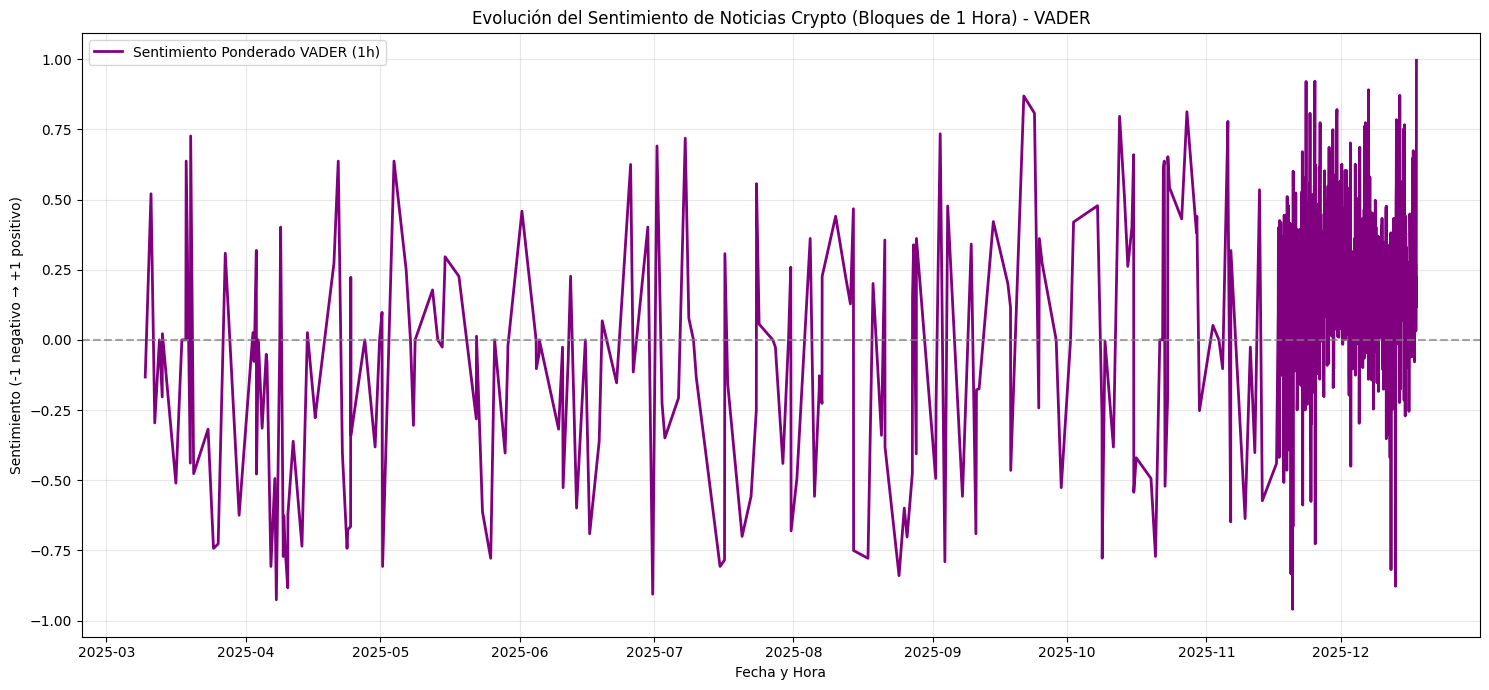

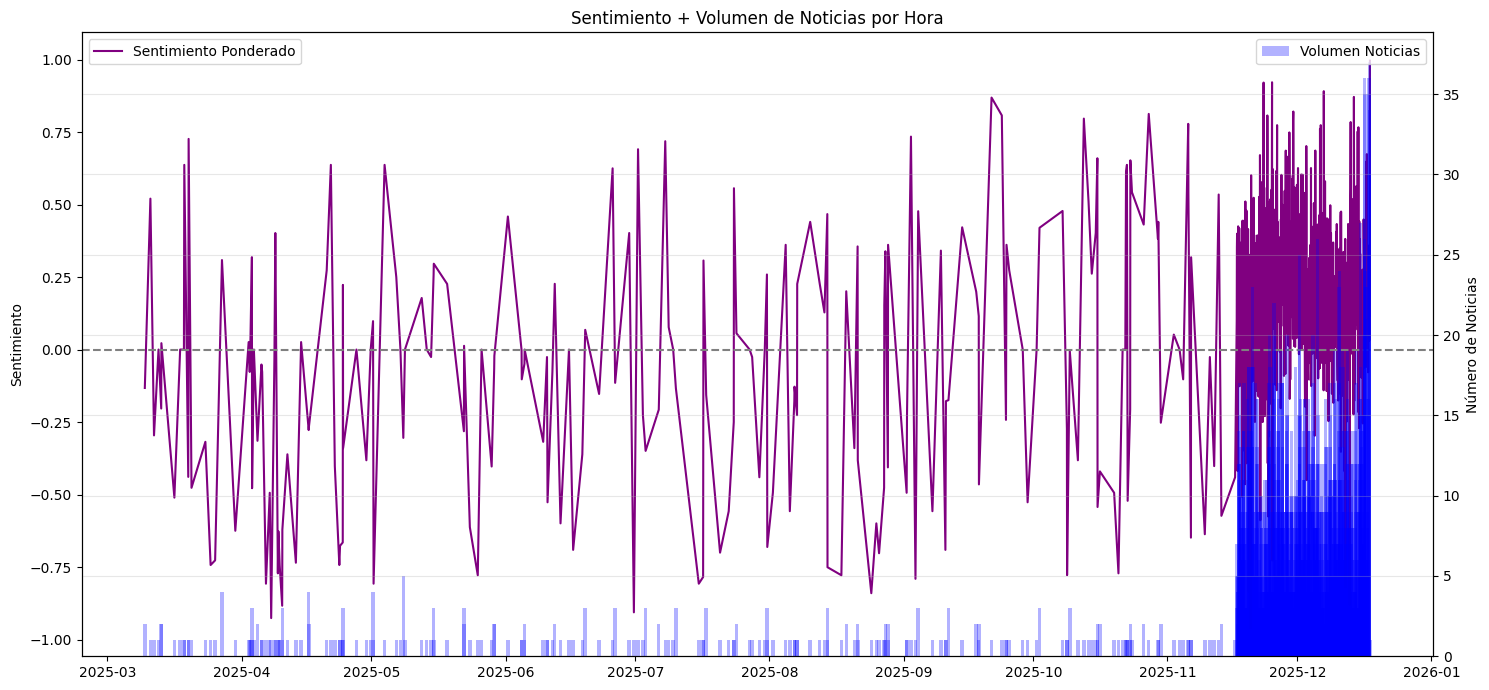

In [15]:
# === VISUALIZACIÓN DEL ÚLTIMO CSV DE SENTIMIENTO 1H ===

import pandas as pd
import matplotlib.pyplot as plt

# AJUSTA EL NOMBRE DEL ÚLTIMO CSV GENERADO
filename = '2025.12.17_sentiment_1h_VADER_RSS.csv'  # <-- Cambia si es diferente (mira la carpeta processed)

df_sent = pd.read_csv(filename, index_col='datetime_1h', parse_dates=True)

print(f"Dataset cargado: {df_sent.shape[0]} bloques de 1h")
print(f"Rango temporal: {df_sent.index.min()} → {df_sent.index.max()}")
print(f"Total noticias procesadas: {df_sent['count_total'].sum():,}")

# Resumen estadístico del sentimiento ponderado
print("\nResumen sentimiento ponderado:")
print(df_sent['sent_weighted_vader'].describe().round(3))

# Últimas 10 filas (lo más reciente)
print("\nÚltimas 10 filas:")
display(df_sent[['sent_weighted_vader', 'sent_total_vader', 
                 'count_total', 'sent_btc_vader', 'sent_tech_vader', 'sent_macro_vader']].tail(10))

# Plot del sentimiento ponderado por hora
plt.figure(figsize=(15, 7))
plt.plot(df_sent.index, df_sent['sent_weighted_vader'], 
         label='Sentimiento Ponderado VADER (1h)', color='purple', linewidth=2)
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
plt.title('Evolución del Sentimiento de Noticias Crypto (Bloques de 1 Hora) - VADER')
plt.ylabel('Sentimiento (-1 negativo → +1 positivo)')
plt.xlabel('Fecha y Hora')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Opcional: Plot con volumen de noticias
fig, ax1 = plt.subplots(figsize=(15, 7))
ax1.plot(df_sent.index, df_sent['sent_weighted_vader'], color='purple', label='Sentimiento Ponderado')
ax1.set_ylabel('Sentimiento')
ax1.axhline(0, color='gray', linestyle='--')

ax2 = ax1.twinx()
ax2.bar(df_sent.index, df_sent['count_total'], alpha=0.3, color='blue', label='Volumen Noticias')
ax2.set_ylabel('Número de Noticias')

plt.title('Sentimiento + Volumen de Noticias por Hora')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()